In [1]:
import numpy as np
import pandas as pd
import sys
from datetime import datetime
import skmap_bindings
from pathlib import Path
import time
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'

gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}
n_threads = 96
bands_list = [1,]

x_size, y_size = (1, 1)
nodata_val = 255
tmp_write_dir = '../tmp'
band_scaling = 0.004
result_scaling = 125.
result_offset = 125.
climping = [0., 250.]
tile = '005E_51N'
month_start = ['0101'
           ,'0301'
           ,'0501'
           ,'0701'
           ,'0901'
           ,'1101']
month_end = ['0228'
           ,'0430'
           ,'0630'
           ,'0831'
           ,'1031'
           ,'1231']
x_offs = [3500, 3500, 1500]
y_offs = [1500, 3500, 3500]
years = range(1997,2023)
tiles = ['144E_07S', '030E_37N', '013E_61N',]
site_ref = ['B', 'A', 'C',]

For tile 144E_07S (site B): Lon = 144.87449645996094, Lat = -7.374499797821045


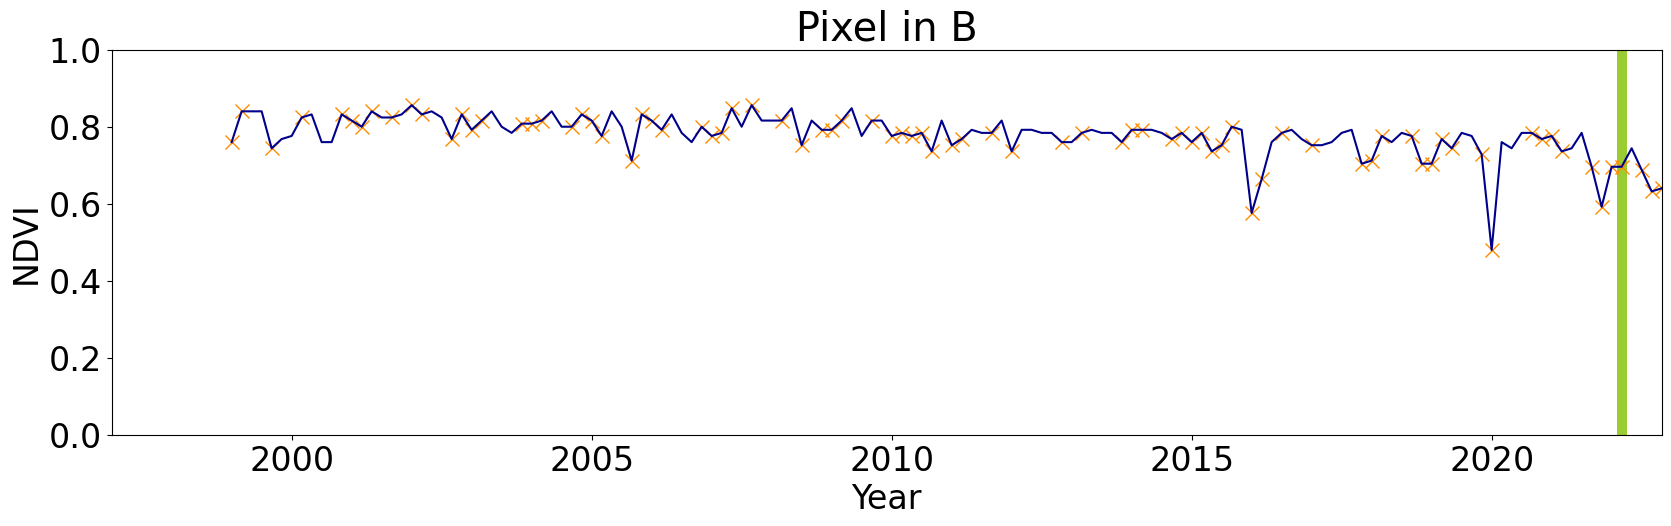

For tile 030E_37N (site A): Lon = 30.874500274658203, Lat = 37.1254997253418


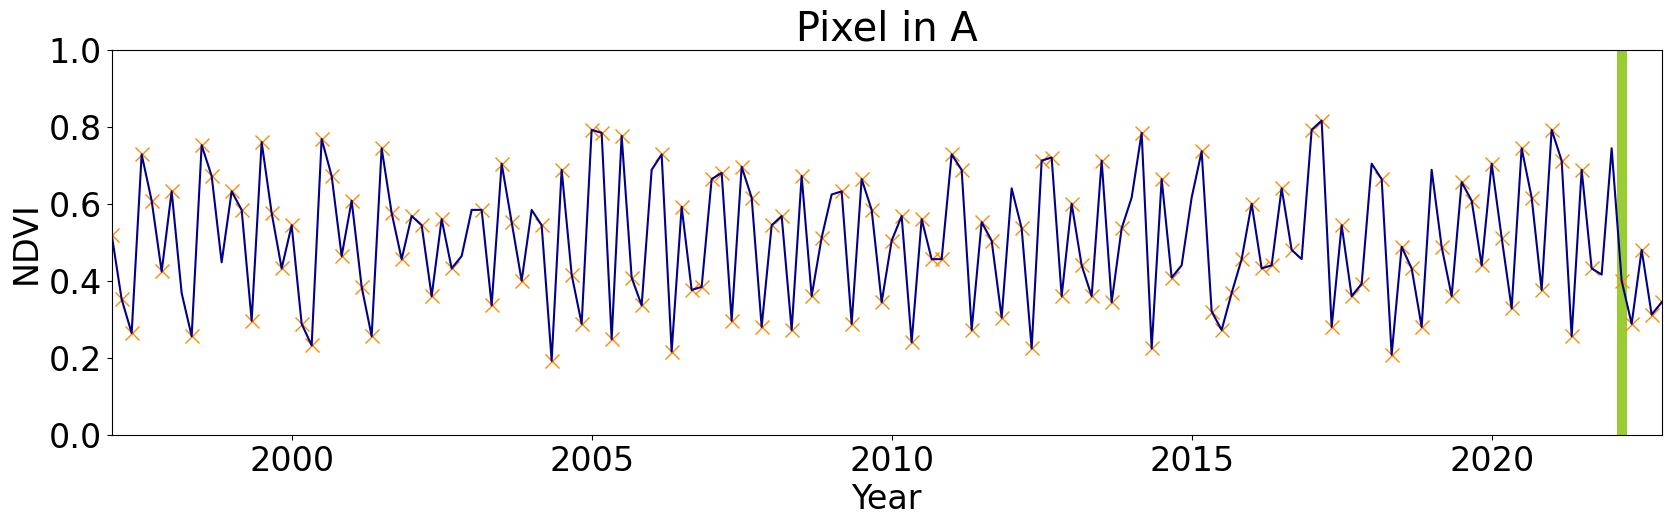

For tile 013E_61N (site C): Lon = 13.374500274658203, Lat = 61.1254997253418


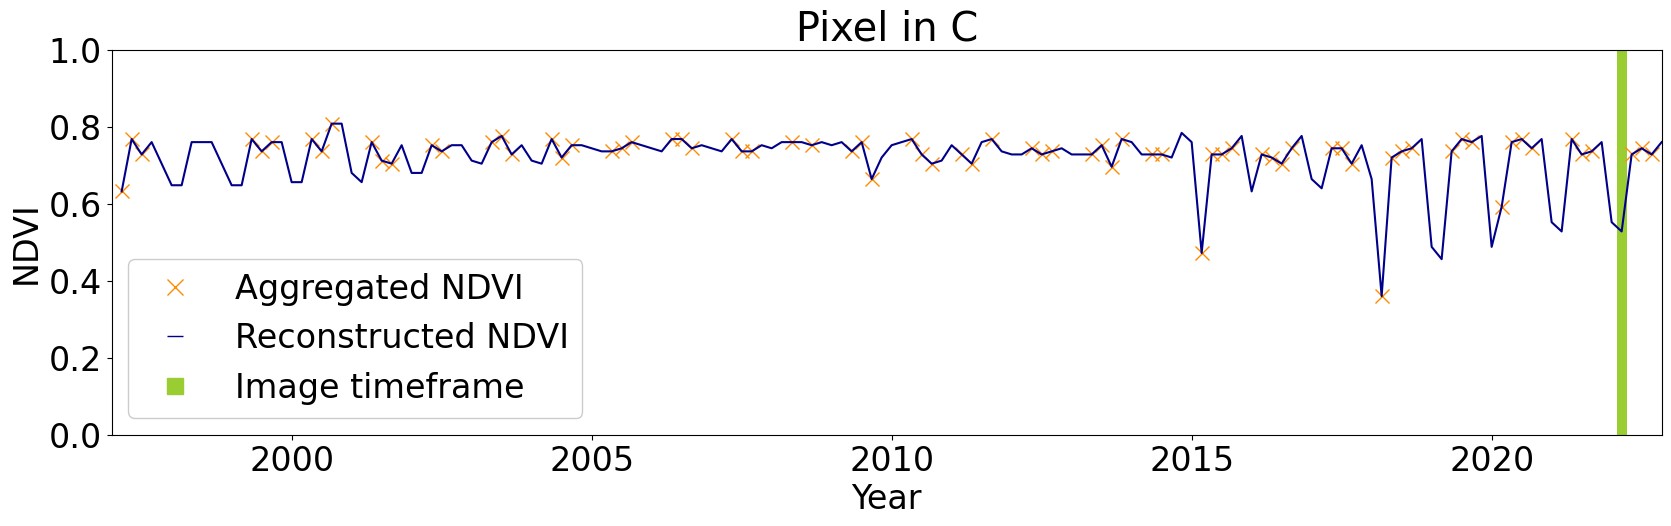

In [2]:
from matplotlib.patches import Rectangle
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 24})
t = float(years[0]) + np.arange(6*len(years))/ 6.
ylim = (0.0, 1.)
for j, tile in enumerate(tiles):
    x_off = x_offs[j]
    y_off = y_offs[j]
    data_filled = np.empty((6*len(years)*3, x_size * y_size), dtype=np.float32)
    data_agg = np.empty((6*len(years)*3, x_size * y_size), dtype=np.float32)
    file_loc = f'http://192.168.49.35:8333/prod-landsat-ard2/{tile}/seasconv/red_glad.SeasConv.ard2_m_30m_s_20000101_20000228_go_epsg.4326_v20230908.tif'
    lon_lat = np.zeros((2,x_size * y_size), dtype=np.float32)
    skmap_bindings.getLatLonArray(lon_lat, n_threads, gdal_opts, file_loc,
                   x_off, y_off, x_size, y_size)
    print(f'For tile {tile} (site {site_ref[j]}): Lon = {lon_lat[0,0]}, Lat = {lon_lat[1,0]}')
    for i, year in enumerate(years):
        start = time.time()
        files_red_filled = [f'http://192.168.49.30:8333/prod-landsat-ard2/{tile}/seasconv/red_glad.SeasConv.ard2_m_30m_s_{year}{month_start[m]}_{year}{month_end[m]}_go_epsg.4326_v20230908.tif' for m in range(6)]
        files_nir_filled = [f'http://192.168.49.30:8333/prod-landsat-ard2/{tile}/seasconv/nir_glad.SeasConv.ard2_m_30m_s_{year}{month_start[m]}_{year}{month_end[m]}_go_epsg.4326_v20230908.tif' for m in range(6)]

        files_red_agg = [f'http://192.168.49.30:8333/prod-landsat-ard2/{tile}/agg/red_glad.ard2_m_30m_s_{year}{month_start[m]}_{year}{month_end[m]}_go_epsg.4326_v20230908.tif' for m in range(6)]
        files_nir_agg = [f'http://192.168.49.30:8333/prod-landsat-ard2/{tile}/agg/nir_glad.ard2_m_30m_s_{year}{month_start[m]}_{year}{month_end[m]}_go_epsg.4326_v20230908.tif' for m in range(6)]
        red_idx = range(6*i, 6*(i+1))
        nir_idx = range(6*len(years)+6*i, 6*len(years)+6*(i+1))
        ndvi_idx = range(2*6*len(years)+6*i, 2*6*len(years)+6*(i+1))

        skmap_bindings.readData(data_filled, n_threads, files_red_filled, red_idx, x_off, y_off, x_size, y_size, bands_list, gdal_opts)
        skmap_bindings.readData(data_filled, n_threads, files_nir_filled, nir_idx, x_off, y_off, x_size, y_size, bands_list, gdal_opts)
        data_filled[data_filled == nodata_val] = np.nan

        skmap_bindings.readData(data_agg, n_threads, files_red_agg, red_idx, x_off, y_off, x_size, y_size, bands_list, gdal_opts)
        skmap_bindings.readData(data_agg, n_threads, files_nir_agg, nir_idx, x_off, y_off, x_size, y_size, bands_list, gdal_opts)
        data_agg[data_agg == nodata_val] = np.nan

        skmap_bindings.computeNormalizedDifference(data_filled, n_threads,
                                                    nir_idx, red_idx, ndvi_idx,
                                                    band_scaling, band_scaling, result_scaling, result_offset, climping)

        skmap_bindings.computeNormalizedDifference(data_agg, n_threads,
                                                    nir_idx, red_idx, ndvi_idx,
                                                    band_scaling, band_scaling, result_scaling, result_offset, climping)
    agg_NDVI = (data_agg[2*6*len(years):3*6*len(years),0] - 125.) / 125.
    filled_NDVI = (data_filled[2*6*len(years):3*6*len(years),0] - 125.) / 125.
    fig, ax = plt.subplots(figsize=(20,5))
    ax.title.set_text(f'Pixel in {site_ref[j]}')
    ax.set_xlabel('Year')
    ax.set_ylabel('NDVI')
    ax.set_xlim(xmin=t[0], xmax=t[-1])
    ax.set_ylim(ymin=ylim[0], ymax=ylim[1])
    ax.plot(t, agg_NDVI, 'x', label = 'Aggregated NDVI', color = 'darkorange', markersize=10)
    ax.plot(t, filled_NDVI, label = 'Reconstructed NDVI', color = 'darkblue')
    ax.add_patch(Rectangle(((t[6*25]+t[6*25+1])/2., ylim[0]), 1./6., ylim[1]-ylim[0],
                 facecolor = 'yellowgreen',
                 fill=True))
    if j==2:
        colors = ["darkorange", "darkblue", "yellowgreen"]
        markers = ["x", "_", "s"]
        labels = ["Aggregated NDVI", "Reconstructed NDVI", "Image timeframe", ]
        f = lambda m,c: plt.plot([],[],marker=m, color=c, markersize=12,  ls="none")[0]
        handles = [f(markers[i], colors[i]) for i in range(3)]
        plt.legend(handles, labels, loc=3, framealpha=1, frameon=True)
    plt.savefig(f'line_plot_site_{site_ref[j]}.svg', format='svg', bbox_inches="tight")
    plt.show()


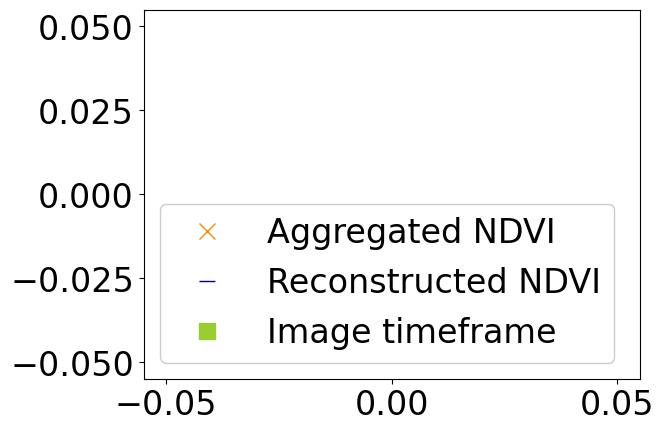

In [3]:
import numpy as np
import matplotlib.pyplot as plt

colors = ["darkorange", "darkblue", "yellowgreen"]
markers = ["x", "_", "s"]
labels = ["Aggregated NDVI", "Reconstructed NDVI", "Image timeframe", ]
f = lambda m,c: plt.plot([],[],marker=m, color=c, markersize=12,  ls="none")[0]
handles = [f(markers[i], colors[i]) for i in range(3)]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=True)

def export_legend(legend, filename="legend.svg", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox, format='svg')

export_legend(legend)
plt.show()